Tarea 3 - Mayte Fuentes, Ana Little

In [1]:
#%%capture#no muestre mucho output hacia abajo
#%pip install -U spacy
#!python -m spacy

In [2]:
#!python -m spacy download es_core_news_sm

In [3]:
import pandas as pd
train_data = pd.read_csv('train_tweets.csv')

In [4]:
train_data

,tweet_id,text,Odio
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0
...,...,...,...
2251,1079889588108312576,Todo me queda para el orto la puta madre que l...,1
2252,1079889409414184960,@DnAkd2947 @AmarasLaPatria Miserable e hijo de...,0
2253,1533855975559639045,@Misael25603414 @sanbenito Cállate mejor 🥰,0
2254,1533852362602840064,@ServicioTelcel 12 msj hoy y 12 mentadas de ma...,1


# Limpieza de datos y preprocesamiento

C:\Users\mayte\AppData\Local\Temp\ipykernel_27104\2742420386.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  words_count = train_data.text.str.replace("|", " ").str.split().apply(len)#replace reemplaza texto


<Axes: ylabel='Frequency'>

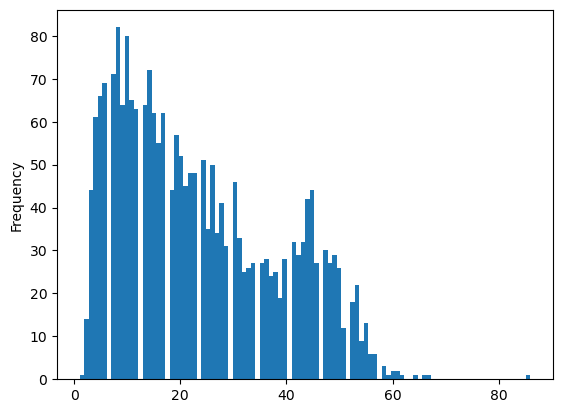

In [5]:
words_count = train_data.text.str.replace("|", " ").str.split().apply(len)#replace reemplaza texto
words_count.plot(kind="hist", bins=100)

Se realiza un conteo de palabras por tweet para revisar si existe alguna anomalia dentro de cada tweet, obteniendo que ninguno tiene cero palabras y a simple vista se consiguio una distribucion mas menos normal.

In [6]:
words_count.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95])#ver los percentiles que nos puedan interesar

count    2256.000000
mean       23.352837
std        14.892090
min         1.000000
25%        11.000000
50%        20.000000
75%        35.000000
80%        39.000000
85%        43.000000
90%        46.000000
95%        50.000000
max        86.000000
Name: text, dtype: float64

Aquí se ratifica el mínimo y máximo que no son mayormente variantes entre sí y se observa que no existe gran diferencia entre cada percentil. Por lo  tanto, no se encontraron celdas sin contenido ni con alta cantidad de datos.

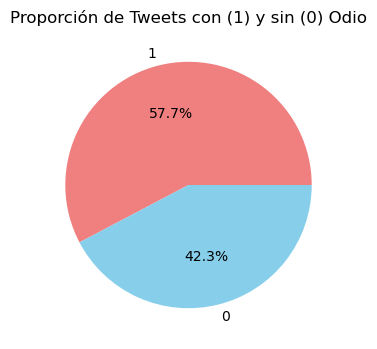

In [7]:
# Contar la cantidad de tweets con y sin odio
import matplotlib.pyplot as plt
conteo_odio = train_data["Odio"].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(conteo_odio, labels=conteo_odio.index, autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
plt.title('Proporción de Tweets con (1) y sin (0) Odio')
plt.show()

In [8]:
# Ver la información del DataFrame
print(train_data.info())
print('-'*30)

# Descripción estadística del conjunto de datos
print(train_data.describe())
print('-'*30)

# Distribución de las etiquetas
print(train_data['Odio'].value_counts())
print('-'*30)

# Visualizar algunos ejemplos de tweets con y sin odio
print("Ejemplos de Tweets sin odio:")
print(train_data[train_data['Odio'] == 0]['text'].sample(5))
print('-'*30)

print("\nEjemplos de Tweets con odio:")
print(train_data[train_data['Odio'] == 1]['text'].sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2256 non-null   int64 
 1   text      2256 non-null   object
 2   Odio      2256 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 53.0+ KB
None
------------------------------
           tweet_id         Odio
count  2.256000e+03  2256.000000
mean   1.382568e+18     0.577128
std    1.661772e+17     0.494125
min    2.480652e+17     0.000000
25%    1.280633e+18     0.000000
50%    1.439822e+18     1.000000
75%    1.533852e+18     1.000000
max    1.544024e+18     1.000000
------------------------------
1    1302
0     954
Name: Odio, dtype: int64
------------------------------
Ejemplos de Tweets sin odio:
803                @serroru y yo me cago en tu puta madre
500       Enamorado de esta mujer https://t.co/wDv23bbcWG
1216                  Moriré llevando negro el Corazón❤️🖤
829     Tí

In [9]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score

# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Cargar tu conjunto de datos
train_data = pd.read_csv('train_tweets.csv')

Para trabajar con los datos de los tweets, que son textos, se utiliza la biblioteca Spacy para identificar las palabras de odio e ir clasificando qué tweets son de odio y cuales no, mediante el modelo "es_core_news_sm" para textos en español.

In [10]:
# Función para extraer información de spaCy
def extract_spacy_info(doc, doc_index=0):
    data_list = []
    for token in doc:
        data = dict()
        data["doc_index"] = doc_index # 1 documento fijo
        data["Text"] = token.text
        data["Lemma"] = token.lemma_ # palabra 'original' (eres, soy, es -> verbo ser)
        data["ent_iob"] = token.ent_iob_
        data["ent_type"] = token.ent_type_ # tipo de entidad
        data["POS"] = token.pos_ # Part Of Speech (tipo de palabra)
        data["is_alpha"] = token.is_alpha # alfanumérico
        data["is_stop"] = token.is_stop
        data_list.append(data)
    return data_list

# Aplicar spaCy al conjunto de datos
data = []
for idx, text in enumerate(train_data.text.values):
    doc = nlp(text)
    data.extend(extract_spacy_info(doc, doc_index=idx))

spacy_df = pd.DataFrame(data)

In [11]:
spacy_df.head()

,doc_index,Text,Lemma,ent_iob,ent_type,POS,is_alpha,is_stop
0,0,En,en,O,,ADP,True,True
1,0,una,uno,O,,DET,True,True
2,0,amistad,amistad,O,,NOUN,True,False
3,0,o,o,O,,CCONJ,True,True
4,0,soy,ser,O,,AUX,True,True


In [12]:
# Función para retokenización
# La función crea un texto 'limpio', eliminando los stopwords que no aportan mayor información a las frases, y cambiando las palabras por su 'lemma' si es posible
# Así, se simplifican las palabras a su forma más básica, permite que el modelo capture mejor las similitudes entre las palabras relacionadas.
# En lugar de lidiar con múltiples formas de la misma palabra, solo te centras en la esencia o raíz de esa palabra.
stopwords = set(spacy_df.query("is_stop == True").Text.str.lower().unique())

def retokenizer(df, column, remove_stopwords=True, lemma=False):
    clean_text_list = []
    for text in df[column].values:
        doc = nlp(text)
        if lemma:
            if remove_stopwords:
                clean_text = " ".join(
                    [token.lemma_ for token in doc if token.is_alpha and token.text.lower() not in stopwords]
                )
            else:
                clean_text = " ".join(
                    [token.lemma_ for token in doc if token.is_alpha]
                )
        else:
            if remove_stopwords:
                clean_text = " ".join(
                    [token.text for token in doc if token.is_alpha and token.text.lower() not in stopwords]
                )
            else:
                clean_text = " ".join(
                    [token.text for token in doc if token.is_alpha]
                )
        clean_text_list.append(clean_text)
    return clean_text_list

# Aplicar retokenización al conjunto de datos
train_data["clean_text"] = retokenizer(train_data, column="text", remove_stopwords=True, lemma=True)
#train_data["clean_lemma"] = retokenizer(train_data, column="text", remove_stopwords=True, lemma=True)


In [13]:
train_data

,tweet_id,text,Odio,clean_text
0,1399516036240662528,En una amistad o soy tipo: \r\nLo peor es que ...,0,amistad tipo lskdkdnff
1,1320788179721560065,QUIEN FUE LA MARACA CULIA TE VOY A MATAR PERRA...,1,maraca CULIA MATAR PERRA MIERDVA
2,1079889645280944129,menos mal q se recibe el año con ropa blanca j...,0,q recibir año ropa blanca jajajajjajajajajjar ...
3,1369254390134145033,Cuantos INFILTRADOS extranjeros hay ahi😡 https...,1,INFILTRADOS extranjero
4,1533854824378290176,#ENCONTRADO #GUAYAQUIL\r\nFecha: 06/06/22\r\nS...,0,encontrado guayaquil Fecha Sector Norte Autopi...
...,...,...,...,...
2251,1079889588108312576,Todo me queda para el orto la puta madre que l...,1,quedar orto puta madre parir
2252,1079889409414184960,@DnAkd2947 @AmarasLaPatria Miserable e hijo de...,0,Miserable hijo puta
2253,1533855975559639045,@Misael25603414 @sanbenito Cállate mejor 🥰,0,Cállate
2254,1533852362602840064,@ServicioTelcel 12 msj hoy y 12 mentadas de ma...,1,msj mentada madre eespirir hijo puta


In [14]:
# SEGUN YO ESTA PARTE NO ES MUY NECESARIA PERO NO CREO QUE AFECTE NEGATIVAMENTE
# Función para crear características adicionales: nro de palabras y de caracteres
def create_additional_features(clean_text, raw_text, spacy_df):
    feature_dict = dict()
    feature_dict["n_words_clean"] = clean_text.str.split().apply(len)
    feature_dict["n_words"] = raw_text.str.split().apply(len)
    feature_dict["n_chars_clean"] = clean_text.str.len()
    feature_dict["n_chars"] = raw_text.str.len()

    # pos_df = (
    #     spacy_df.groupby(["doc_index", "POS"], as_index=False)
    #     .size()
    #     .pivot(index="doc_index", columns="POS")
    #     .fillna(0)
    # )
    # pos_df.columns = pos_df.columns.droplevel()

    return pd.DataFrame(feature_dict)#.join(pos_df)

# Crear características adicionales
additional_features = create_additional_features(
    train_data["clean_text"], train_data["text"], spacy_df
)

In [15]:
# Vectorización del texto con TfidfVectorizer
tdf = TfidfVectorizer(min_df=10) # solo palabras que aparezcan min 10 veces
features_tfidf = tdf.fit_transform(train_data["clean_text"]).toarray()
features_names_tfidf = tdf.get_feature_names_out()

# Crear un DataFrame con las características de TfidfVectorizer
df_tfidf = pd.DataFrame(features_tfidf, columns=features_names_tfidf)

# # Fusionar características de TfidfVectorizer y características adicionales
# merged_features = pd.concat([df_tfidf], axis=1)

# merged_features.head()

# Fusionar características de TfidfVectorizer y características adicionales
merged_features = pd.merge(
    pd.DataFrame(features_tfidf, columns=features_names_tfidf),
    additional_features,
    left_index=True,
    right_index=True
)

merged_features.head()

,aborto,acabar,acoso,acá,alguien,alto,amar,amariconao,amiga,amigo,...,wn,xq,yo,zorra,él,único,n_words_clean,n_words,n_chars_clean,n_chars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,15,22,92
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,12,32,57
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8,15,53,88
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,6,22,64
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24,35,185,280


In [16]:
columnas_merged_features = merged_features.columns.tolist()
print(columnas_merged_features)


['aborto', 'acabar', 'acoso', 'acá', 'alguien', 'alto', 'amar', 'amariconao', 'amiga', 'amigo', 'anda', 'andar', 'aparte', 'aportar', 'apoyar', 'asco', 'asesino', 'asqueroso', 'atención', 'aweonao', 'año', 'bandera', 'bastarda', 'bastardo', 'blanco', 'boca', 'boric', 'buscar', 'caer', 'cagar', 'callate', 'calle', 'cambiar', 'cara', 'carabinero', 'casa', 'caso', 'centro', 'chile', 'chileno', 'chilenos', 'chupar', 'clase', 'colombiano', 'comer', 'comunista', 'conchetumare', 'cosa', 'costumbre', 'creer', 'ctm', 'cuerpo', 'culia', 'culiao', 'culiaos', 'culo', 'culpa', 'cállate', 'dar', 'deber', 'decidir', 'decir', 'defender', 'dejar', 'delincuente', 'delito', 'derecho', 'desear', 'destruir', 'difícil', 'dinero', 'dios', 'dormir', 'echar', 'ejemplo', 'empezar', 'entender', 'entrar', 'esperar', 'estar', 'etc', 'extranjero', 'falso', 'falta', 'faltar', 'familia', 'favor', 'feliz', 'feminazi', 'feminazis', 'feminista', 'feo', 'fiesta', 'flojo', 'foto', 'gana', 'ganar', 'gay', 'gente', 'gobiern

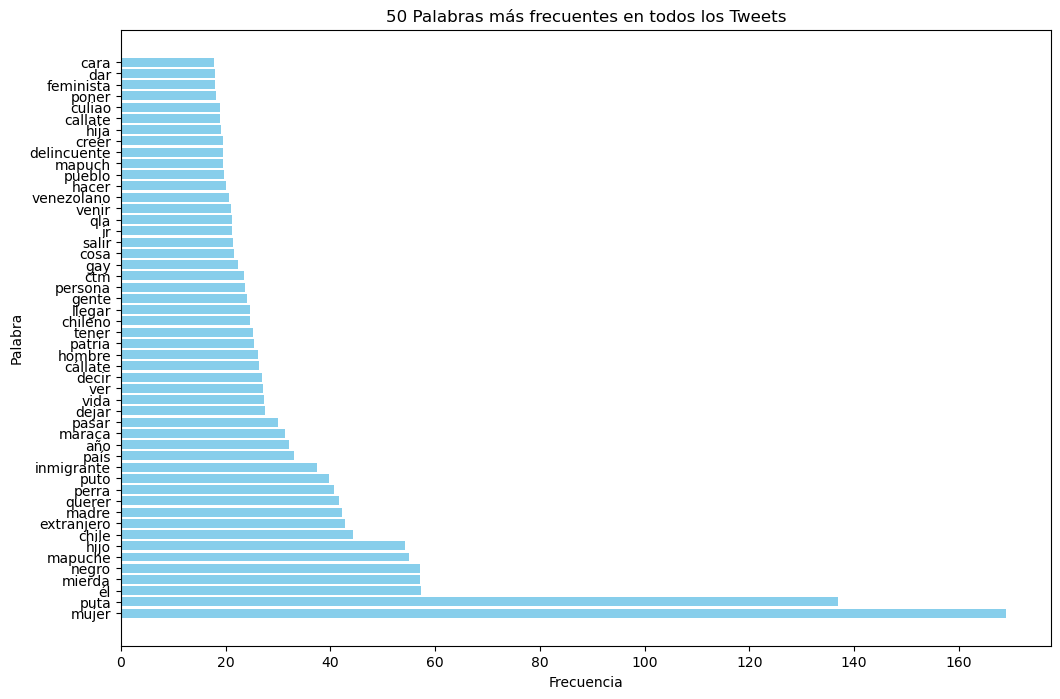

In [17]:
import matplotlib.pyplot as plt

# Excluir las columnas específicas
columnas_a_excluir = ['n_words_clean', 'n_words', 'n_chars_clean', 'n_chars']
frecuencias_por_palabra = merged_features.drop(columns=columnas_a_excluir).sum(axis=0)

# Crear un DataFrame con las palabras y sus frecuencias
df_frecuencias = pd.DataFrame({'Palabra': frecuencias_por_palabra.index, 'Frecuencia': frecuencias_por_palabra.values})

# Ordenar el DataFrame por frecuencia en orden descendente
df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False)

# Tomar las primeras N palabras para visualización (ajusta según tus necesidades)
top_n_palabras = 50
df_top_palabras = df_frecuencias.head(top_n_palabras)

# Crear un barplot
plt.figure(figsize=(12, 8))
plt.barh(df_top_palabras['Palabra'], df_top_palabras['Frecuencia'], color='skyblue')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('50 Palabras más frecuentes en todos los Tweets')
plt.show()

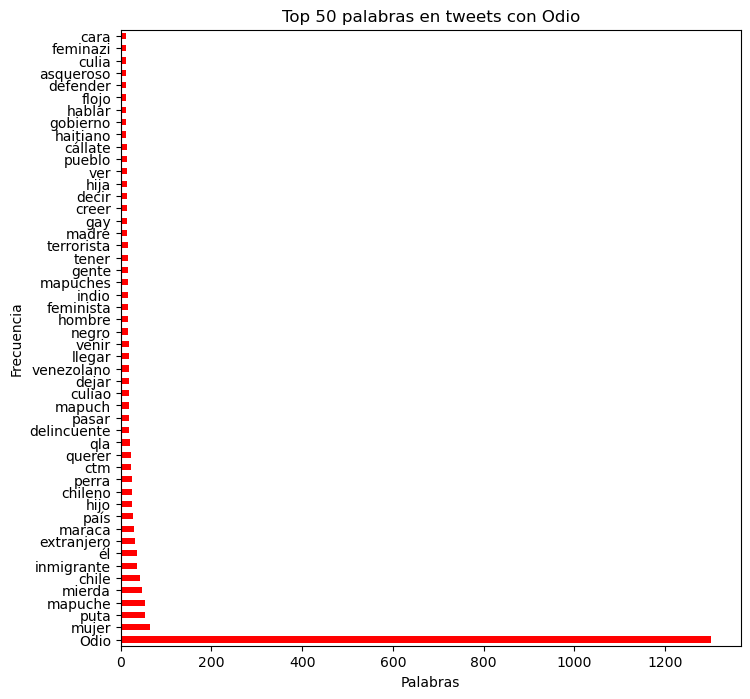

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que 'Odio' está presente en train_data y merged_features
train_data["Odio"] = train_data["Odio"].astype(int)  # Asegurar que la columna 'Odio' sea de tipo entero

# Fusionar 'Odio' con merged_features
merged_data = pd.concat([merged_features, train_data["Odio"]], axis=1)

# Definir columnas a excluir
columnas_a_excluir = ['n_words_clean', 'n_words', 'n_chars_clean', 'n_chars']

# Filtrar columnas a incluir en el análisis
columnas_a_incluir = [col for col in merged_data.columns if col not in columnas_a_excluir]

# Visualizar top de palabras que aparecen en tweets con Odio (ignorando columnas especificadas)
top_words_with_hate = merged_data.loc[merged_data["Odio"] == 1, columnas_a_incluir].sum().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(8, 8))
top_words_with_hate[:50].plot(kind="barh", color='red')
plt.title("Top 50 palabras en tweets con Odio")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()


**BÚSQUEDA DE HIPERPARÁMETROS**

In [19]:
## SVM
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Definir la distribución de hiperparámetros a ajustar
param_dist = {
    'model__C': [0.01, 0.1, 1, 10, 1000],
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

# Crear un pipeline con el modelo SVM
svm_pipe = Pipeline(steps=[('model', SVC())])

# Inicializar el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(svm_pipe, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)

y = train_data["Odio"]
# Realizar la búsqueda aleatoria de hiperparámetros
random_search.fit(merged_features, y)

# Obtener los mejores hiperparámetros
best_params = random_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Obtener los resultados de la búsqueda aleatoria
cv_results = pd.DataFrame(random_search.cv_results_)


In [ ]:
# RANDOM FOREST

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir la distribución de hiperparámetros a ajustar para Random Forest
param_dist_rf = {
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}

# Crear un pipeline con el modelo Random Forest
rf_pipe = Pipeline(steps=[('model', RandomForestClassifier())])

# Inicializar el objeto RandomizedSearchCV para Random Forest
random_search_rf = RandomizedSearchCV(rf_pipe, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='f1', n_jobs=-1, random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros para Random Forest
random_search_rf.fit(merged_features, y)

# Obtener los mejores hiperparámetros para Random Forest
best_params_rf = random_search_rf.best_params_
print(f"Mejores hiperparámetros para Random Forest: {best_params_rf}")

# Obtener los resultados de la búsqueda aleatoria para Random Forest
cv_results_rf = pd.DataFrame(random_search_rf.cv_results_)

Mejores hiperparámetros para Random Forest: {'model__n_estimators': 150, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 20}


In [ ]:
# GRADIENT BOOSTING

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Definir la distribución de hiperparámetros a ajustar para Gradient Boosting
param_dist_gb = {
    'model__n_estimators': [50, 100, 150],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
}

# Crear un pipeline con el modelo Gradient Boosting
gb_pipe = Pipeline(steps=[('model', GradientBoostingClassifier())])

# Inicializar el objeto RandomizedSearchCV para Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_pipe, param_distributions=param_dist_gb, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros para Gradient Boosting
random_search_gb.fit(merged_features, y)

# Obtener los mejores hiperparámetros para Gradient Boosting
best_params_gb = random_search_gb.best_params_
print(f"Mejores hiperparámetros para Gradient Boosting: {best_params_gb}")

# Obtener los resultados de la búsqueda aleatoria para Gradient Boosting
cv_results_gb = pd.DataFrame(random_search_gb.cv_results_)


/Library/Python/3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Mejores hiperparámetros para Gradient Boosting: {'model__n_estimators': 100, 'model__max_depth': 5, 'model__learning_rate': 0.2}


In [ ]:
# NAIVE BAYES

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Definir la distribución de hiperparámetros a ajustar para Naive Bayes
param_dist = {
    'model__alpha': np.logspace(-3, 3, 7),  # Rango de valores para el hiperparámetro alpha
}

# Crear un pipeline con el modelo Naive Bayes
nb_pipe = Pipeline(steps=[('model', MultinomialNB())])

# Inicializar el objeto RandomizedSearchCV
random_search_nb = RandomizedSearchCV(nb_pipe, param_distributions=param_dist, n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=42)

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_nb.fit(merged_features, y)

# Obtener los mejores hiperparámetros
best_params_nb = random_search_nb.best_params_
print(f"Mejores hiperparámetros para Naive Bayes: {best_params_nb}")

# Obtener los resultados de la búsqueda aleatoria
cv_results_nb = pd.DataFrame(random_search_nb.cv_results_)

Mejores hiperparámetros para Naive Bayes: {'model__alpha': 0.001}


/Library/Python/3.9/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 7 is smaller than n_iter=50. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Dummy Classifier: 0.7319 +- 0.0007
SVM: 0.7315 +- 0.0012
Naive Bayes: 0.7423 +- 0.0105
Ensemble (SVM + NB): 0.7423 +- 0.0105
Gradient Boosting: 0.7469 +- 0.008
Random Forest: 0.7332 +- 0.0207


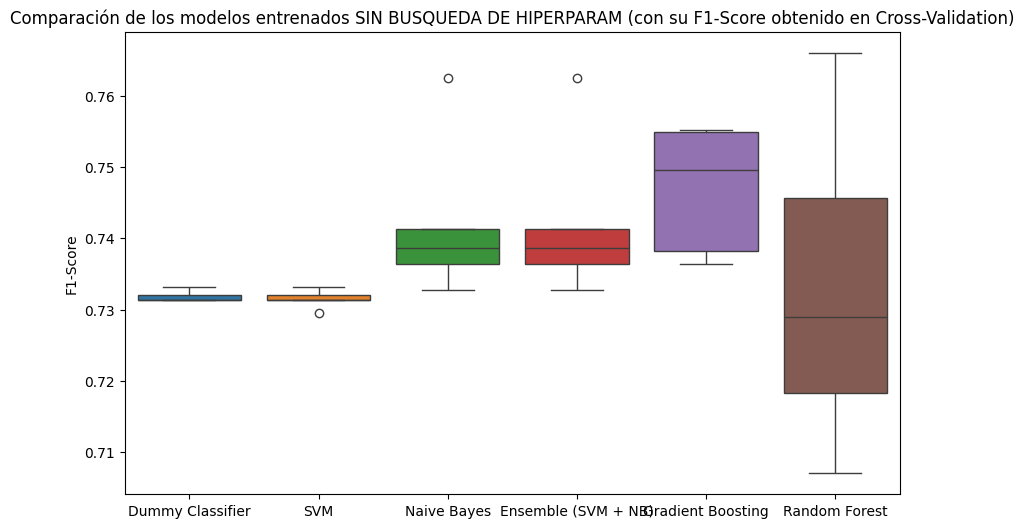

In [ ]:
# Crear un pipeline y entrenar modelos SIN BÚSQUEDA DE HIPERPARAM
from sklearn.dummy import DummyClassifier
y = train_data["Odio"]

classifiers = {
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Ensemble (SVM + NB)": VotingClassifier(estimators=[("svm", SVC()), ("nb", MultinomialNB())]),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_results = pd.DataFrame() # para guardar los resultados de cada iteración por modelo

for name, model in classifiers.items():
    pipe = Pipeline(steps=[("model", model)])

    f1_scorer = make_scorer(f1_score)
    cv_scores = cross_val_score(pipe, merged_features, y, cv=5, scoring=f1_scorer)

    print(f"{name}: {cv_scores.mean().round(4)} +- {cv_scores.std().round(4)}")
    cv_results[name] = cv_scores

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_results)
plt.title('Comparación de los modelos entrenados SIN BUSQUEDA DE HIPERPARAM (con su F1-Score obtenido en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

Dummy Classifier: 0.7319 +- 0.0007
SVM: 0.7643 +- 0.0115
Naive Bayes: 0.7497 +- 0.0119
Ensemble (SVM + NB): 0.748 +- 0.0172
Gradient Boosting: 0.7547 +- 0.0148
Random Forest: 0.7542 +- 0.0099


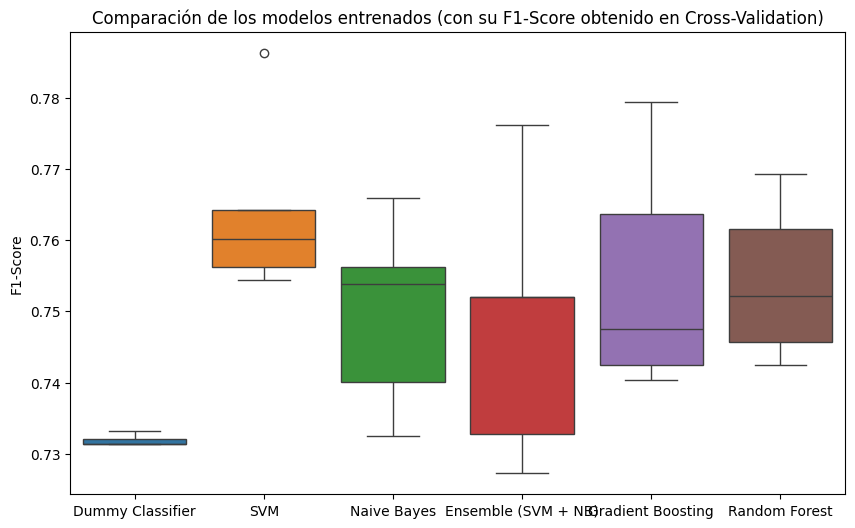

In [ ]:
# Crear un pipeline y entrenar modelos PROBANDO HIPERPARAM en el pc
y = train_data["Odio"]

classifiers = {
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
    "SVM": SVC(kernel='linear', C=0.1),
    "Naive Bayes": MultinomialNB(alpha=0.001),
    "Ensemble (SVM + NB)": VotingClassifier(estimators=[("svm", SVC(kernel='linear', C=0.1)), ("nb", MultinomialNB(alpha=0.001))]),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=7, learning_rate=0.2),
    "Random Forest": RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_depth=20)
}

cv_results = pd.DataFrame() # para guardar los resultados de cada iteración por modelo

for name, model in classifiers.items():
    pipe = Pipeline(steps=[("model", model)])

    f1_scorer = make_scorer(f1_score)
    cv_scores = cross_val_score(pipe, merged_features, y, cv=5, scoring=f1_scorer)

    print(f"{name}: {cv_scores.mean().round(4)} +- {cv_scores.std().round(4)}")
    cv_results[name] = cv_scores

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_results)
plt.title('Comparación de los modelos entrenados (con su F1-Score obtenido en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

Dummy Classifier: 0.7319 +- 0.0007
SVM: 0.7464 +- 0.0121
Naive Bayes: 0.7497 +- 0.0119
Ensemble (SVM + NB): 0.7428 +- 0.0174
Gradient Boosting: 0.7526 +- 0.0073
Random Forest: 0.7549 +- 0.0146


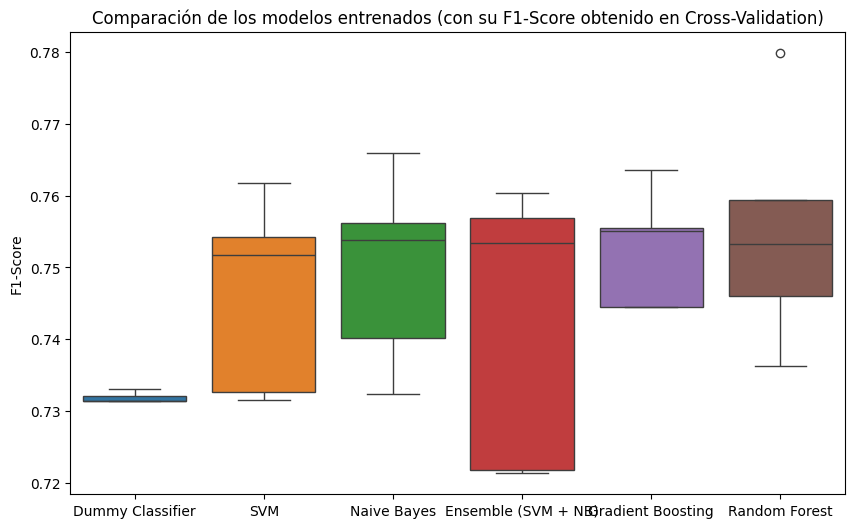

In [ ]:
# Crear un pipeline y entrenar modelos PROBANDO HIPERPARAM 2 en el pc
y = train_data["Odio"]

classifiers = {
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
    "SVM": SVC(kernel='rbf', C=1000),
    "Naive Bayes": MultinomialNB(alpha=0.001),
    "Ensemble (SVM + NB)": VotingClassifier(estimators=[("svm", SVC(kernel='rbf', C=1000)), ("nb", MultinomialNB(alpha=0.001))]),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.2),
    "Random Forest": RandomForestClassifier(n_estimators=150, min_samples_split=5, min_samples_leaf=1, max_depth=20)
}

cv_results = pd.DataFrame() # para guardar los resultados de cada iteración por modelo

for name, model in classifiers.items():
    pipe = Pipeline(steps=[("model", model)])

    f1_scorer = make_scorer(f1_score)
    cv_scores = cross_val_score(pipe, merged_features, y, cv=5, scoring=f1_scorer)

    print(f"{name}: {cv_scores.mean().round(4)} +- {cv_scores.std().round(4)}")
    cv_results[name] = cv_scores

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_results)
plt.title('Comparación de los modelos entrenados (con su F1-Score obtenido en Cross-Validation)')
plt.ylabel('F1-Score')
plt.show()

# Predecir

Hay que hacerlo solo con un modelo, tenemos que elegir el mejor

In [ ]:
# Entrenar modelos con todo el conjunto de entrenamiento
classifiers = {
    "SVM": SVC(kernel='linear', C=0.1),
    "Naive Bayes": MultinomialNB(alpha=0.001),
    "Ensemble (SVM + NB)": VotingClassifier(estimators=[("svm", SVC(kernel='linear', C=0.1)), ("nb", MultinomialNB(alpha=0.001))]),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=7, learning_rate=0.2),
    "Random Forest": RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_depth=20)
}

# Cargar conjunto de datos de prueba
test_data = pd.read_csv('test_tweets.csv')

# Aplicar spaCy al conjunto de datos de prueba
data = []
for idx, text in enumerate(test_data.text.values):
    doc = nlp(text)
    data.extend(extract_spacy_info(doc, doc_index=idx))

spacy_df_test = pd.DataFrame(data)

# Aplicar retokenización al conjunto de datos de prueba
test_data["clean_text"] = retokenizer(test_data, column="text")

# Crear características adicionales para el conjunto de datos de prueba
additional_features_test = create_additional_features(
    test_data["clean_text"], test_data["text"], spacy_df_test
)

# Vectorizar el texto con TfidfVectorizer para el conjunto de datos de prueba
features_tfidf_test = tdf.transform(test_data["clean_text"]).toarray()

# Fusionar características de TfidfVectorizer y características adicionales para el conjunto de datos de prueba
merged_features_test = pd.merge(
    pd.DataFrame(features_tfidf_test, columns=features_names_tfidf),
    additional_features_test,
    left_index=True,
    right_index=True
)

# Hacer predicciones con cada modelo en el conjunto de datos de prueba
predictions = dict()

for name, model in classifiers.items():
    model.fit(merged_features, train_data["Odio"])  # Entrenar el modelo con todo el conjunto de entrenamiento
    y_pred_test = model.predict(merged_features_test)
    predictions[name] = y_pred_test

# Agregar las predicciones al conjunto de datos de prueba
for name, y_pred_test in predictions.items():
    test_data[name] = y_pred_test

In [ ]:
test_data.head()

,tweet_id,text,clean_text,SVM,Naive Bayes,Ensemble (SVM + NB),Gradient Boosting,Random Forest
0,1533854540763742209,Estoy de acuerdo que corrijas a tus hijos pero...,corrijas hijos tratarlos Par hijos puta,0,0,0,0,0
1,1277756504519725057,@danieljadue @ArquitectsPC1 Te regalo un pico ...,regalo pico pa lleguis poto wn hueco,1,1,1,1,1
2,1529500412402757632,@Nnicolas_M @carolinawagner_ @i_krmns El paro ...,paro camineros excepción gobierno ministra evi...,1,1,1,1,1
3,1167425893066838016,"@vroteberde Estoy en la misma, hoy no laburo c...",laburo,1,0,0,0,0
4,1399515878727749632,@beudalgoaj puta merda,puta merda,0,0,0,0,0


In [ ]:
# Crear un DataFrame con los tweet_id y las predicciones
result_df = test_data[['tweet_id']].copy()

for name, y_pred_test in predictions.items():
    result_df[name] = y_pred_test

# Guardar el DataFrame de las predicciones en un archivo CSV
result_df.to_csv('result_predictions.csv', index=False)


In [ ]:
result_df

,tweet_id,SVM,Naive Bayes,Ensemble (SVM + NB),Gradient Boosting,Random Forest
0,1533854540763742209,0,0,0,0,0
1,1277756504519725057,1,1,1,1,1
2,1529500412402757632,1,1,1,1,1
3,1167425893066838016,1,0,0,0,0
4,1399515878727749632,0,0,0,0,0
...,...,...,...,...,...,...
2286,1469006079782645762,1,1,1,1,1
2287,1528569883868508161,0,0,0,0,0
2288,1502776153001455616,1,1,1,1,1
2289,1540938860363907073,1,0,0,1,1
